---
---

# `Predicción de Resultados de Fútbol con Machine Learning`

---
---
# 1. Descripción General del Proyecto

**1.1** Introducción
El fútbol es un deporte caracterizado por alta incertidumbre y bajo número de eventos (goles), esto lo convierte en un caso ideal para el uso de modelos probabilísticos. La forma reciente de los equipos es más relevante que su rendimiento histórico completo. Por ello, el proyecto se enfoca en features dinámicas basadas en ventanas temporales.

**1.2** Objetivo
Construir un modelo estadístico que estime probabilidades de:
- Victoria local
- Empate
- Victoria visitante

**1.3** Alcance del proyecto
- Análisis exploratorio (EDA)
- Feature engineering con ventanas móviles
- Modelos probabilísticos
- Evaluación con métricas apropiadas (log loss)

`El énfasis del proyecto no está en la predicción determinista, sino en la correcta calibración y evaluación probabilística de los modelos.`

---


# 2. Importar de librerias

In [1]:
# Análisis de Datos y Manipulación
import pandas as pd
import numpy as np
import math as mt
from scipy import stats as st
from scipy.stats import chi2_contingency

# Machine Learning: Entrenamiento, Modelado y Evaluación
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, log_loss, classification_report, confusion_matrix)
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
from sklearn.calibration import calibration_curve
from sklearn.calibration import CalibratedClassifierCV

# Procesamiento de Texto y Comparación Semántica (para limpiar nombres de equipos)
import difflib

# Guarda Modelo
import joblib

# Visualización
import matplotlib.pyplot as plt
import seaborn as sns

# 3. Carga y Descripción de datos

In [2]:
# Carga del dataset de partidos del 2012-2024
matches = pd.read_csv(r"D:\101010 Revisiones\GitHub\liga-mx-match-prediction\Data\Matches.csv", low_memory=False)

# Carga del dataset de partidos 2025-2026
liga_mx2025 = pd.read_csv(r"D:\101010 Revisiones\GitHub\liga-mx-match-prediction\Data\Liga_mx2025.csv", encoding='latin-1', low_memory=False)

Se filtraran unicamente los datos que correspondan a la Liga MX (Liga principal de México)

In [3]:
# Filtrado de datos para ligas de México por la columna ['Division] = 'MEX' para el dataset matches
liga_mx2012_2024 = matches[matches['Division'] == 'MEX']

In [4]:
#Funcion para el diagnóstico inicial de los datos
def fun_diagnóstico (df):
    print("ESTRUCTURA GENERAL")
    print(df.shape)
    print("COLUMNAS Y TIPOS DE DATOS")
    print(df.info())
    print()
    print("MUESTRA DE LOS DATOS")
    print(df.sample(5))

Se cuenta con 2 datasets: 

- a) resultados de partidos de 2012 a 2024
- b) resultados de partidos de 2025

In [5]:
# LLamada a la función de diagnóstico inicial de datos
print(" === liga mx 12-24 === ")
fun_diagnóstico (liga_mx2012_2024)

 === liga mx 12-24 === 
ESTRUCTURA GENERAL
(4080, 42)
COLUMNAS Y TIPOS DE DATOS
<class 'pandas.core.frame.DataFrame'>
Index: 4080 entries, 73409 to 226115
Data columns (total 42 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Division     4080 non-null   object 
 1   MatchDate    4080 non-null   object 
 2   MatchTime    4071 non-null   object 
 3   HomeTeam     4080 non-null   object 
 4   AwayTeam     4080 non-null   object 
 5   HomeElo      0 non-null      float64
 6   AwayElo      0 non-null      float64
 7   Form3Home    4080 non-null   float64
 8   Form5Home    4080 non-null   float64
 9   Form3Away    4080 non-null   float64
 10  Form5Away    4080 non-null   float64
 11  FTHome       4080 non-null   float64
 12  FTAway       4080 non-null   float64
 13  FTResult     4080 non-null   object 
 14  HTHome       0 non-null      float64
 15  HTAway       0 non-null      float64
 16  HTResult     0 non-null      object 
 17  HomeShots

In [6]:
# LLamada a la función de diagnóstico inicial de datos
print(" === liga mx 2025 === ")
fun_diagnóstico (liga_mx2025)

 === liga mx 2025 === 
ESTRUCTURA GENERAL
(196, 9)
COLUMNAS Y TIPOS DE DATOS
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 196 entries, 0 to 195
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   MatchDate   196 non-null    object
 1   Match_Time  196 non-null    object
 2   League      196 non-null    object
 3   HomeTeam    196 non-null    object
 4   AwayTeam    196 non-null    object
 5   FTHome      196 non-null    int64 
 6   FTAway      196 non-null    int64 
 7   FTResult    196 non-null    object
 8   country     196 non-null    object
dtypes: int64(2), object(7)
memory usage: 13.9+ KB
None

MUESTRA DE LOS DATOS
      MatchDate Match_Time  League   HomeTeam       AwayTeam  FTHome  FTAway  \
47   23/08/2025      17:00  LigaMX       León        Pachuca       1       1   
165  03/12/2025      21:10  LigaMX  Monterrey      Toluca FC       1       0   
76   20/09/2025      17:00  LigaMX    Pachuca      Querétaro 

## Observaciones

`liga_mx2012_2024`

Este dataset es una colección de resultados de partidos hitóricos y estadísticas del portal https://www.football-data.co.uk/ Los datos están ordenados por fecha empezando el 1 de Septiembre de 2012 y con finalización el dia 5 de Diciembre de 2024. El dataset contiene la información mas importante de ambos equipos (Local vs. Visitante) y del partido en si. El dataset está altamente incompleto debido a las diferentes estadísticas que manejan los organismos de fútbol, sin embargo es posible limpiar estos valores nulos.

`liga_mx2025`

Este dataset es una colección de resultados de partidos hitóricos recopiladas del portal https://www.espn.com.mx/futbol/resultados/_/fecha/20250304 están ordenados por fecha empezando el 11 de Julio de 2025 y con finalización el dia 14 de Diciembre de 2025. El dataset contiene unicamente el resultado del partido en si. 

Entre ambos datasets existe un total de 4285 entradas **este volumen es típico para ligas nacionales y condiciona el tipo de modelos viables.**

Plan de Acción

1. Se renombran columnas para:
- mantener consistencia semántica
- facilitar el feature engineering
- evitar ambigüedad entre local y visitante
2. Se convierten columnas date al formato datetime
3. Selección y Estandarización de columnas necesarias para crear "Rolling Windows"
4. CUración de datos:
- estandarización de nombres de equipos
5. Unión de ambos datasets
6. Manejo valores nulos:
7. Creación nuevas features basadas en estadísticas históricas y recientes (ventanas móviles)
8. Análisis Exploratorio
9. Modelos de ML
10. Conclusiones


# 3. Limpieza y Procesamiemto de los Datos

**3.1** Tratamiento de ambos datasets al tipo correcto antes de la union

In [7]:
# Columnas date al tipo de dato correcto
liga_mx2012_2024 = liga_mx2012_2024.copy()
liga_mx2012_2024['MatchDate'] = pd.to_datetime(liga_mx2012_2024['MatchDate'], format='ISO8601')

liga_mx2012_2024.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4080 entries, 73409 to 226115
Data columns (total 42 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Division     4080 non-null   object        
 1   MatchDate    4080 non-null   datetime64[ns]
 2   MatchTime    4071 non-null   object        
 3   HomeTeam     4080 non-null   object        
 4   AwayTeam     4080 non-null   object        
 5   HomeElo      0 non-null      float64       
 6   AwayElo      0 non-null      float64       
 7   Form3Home    4080 non-null   float64       
 8   Form5Home    4080 non-null   float64       
 9   Form3Away    4080 non-null   float64       
 10  Form5Away    4080 non-null   float64       
 11  FTHome       4080 non-null   float64       
 12  FTAway       4080 non-null   float64       
 13  FTResult     4080 non-null   object        
 14  HTHome       0 non-null      float64       
 15  HTAway       0 non-null      float64       
 16  HTRes

In [8]:
# Columnas date al tipo de dato correcto
liga_mx2025['MatchDate'] = pd.to_datetime(liga_mx2025['MatchDate'], format='%d/%m/%Y')

liga_mx2025.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 196 entries, 0 to 195
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   MatchDate   196 non-null    datetime64[ns]
 1   Match_Time  196 non-null    object        
 2   League      196 non-null    object        
 3   HomeTeam    196 non-null    object        
 4   AwayTeam    196 non-null    object        
 5   FTHome      196 non-null    int64         
 6   FTAway      196 non-null    int64         
 7   FTResult    196 non-null    object        
 8   country     196 non-null    object        
dtypes: datetime64[ns](1), int64(2), object(6)
memory usage: 13.9+ KB


**3.2** Selección y Estandarización de columnas necesarias para crear "Rolling Windows"

In [9]:
# Unicamente columnas que nos interesan en liga_mx2012-2024
liga_mx2012_2024 = liga_mx2012_2024[['MatchDate', 'MatchTime', 'HomeTeam', 'AwayTeam', 'FTHome', 'FTAway', 'FTResult']]

# Renombrar columnas para liga_mx2012_2024
liga_mx2012_2024 = liga_mx2012_2024.rename(columns={
    'MatchDate': 'date',
    'MatchTime': 'time',
    'HomeTeam': 'home_team',
    'AwayTeam': 'away_team',
    'FTHome': 'home_goals',
    'FTAway': 'away_goals',
    'FTResult': 'result'
})

# Renombrar columnas para liga_mx2012_2024
liga_mx2025 = liga_mx2025.rename(columns={
    'MatchDate': 'date',
    'Match_Time': 'time',
    'League': 'league',
    'HomeTeam': 'home_team',
    'AwayTeam': 'away_team',
    'FTHome': 'home_goals',
    'FTAway': 'away_goals',
    'FTResult': 'result'
})

# Orden cronológico (CRÍTICO)
liga_mx2012_2024 = liga_mx2012_2024.sort_values('date').reset_index(drop=True)
liga_mx2025 = liga_mx2025.sort_values('date').reset_index(drop=True)

In [10]:
liga_mx2012_2024.head() 


,date,time,home_team,away_team,home_goals,away_goals,result
0,2012-01-09,01:30:00,Club Tijuana,Chiapas,2.0,0.0,H
1,2012-01-09,03:30:00,Monarcas,U.N.A.M.- Pumas,0.0,1.0,A
2,2012-01-09,23:00:00,Cruz Azul,Pachuca,1.0,1.0,D
3,2012-01-09,23:00:00,Queretaro,Atlante,0.0,1.0,A
4,2012-01-10,00:00:00,Atlante,Santos Laguna,1.0,3.0,A


In [11]:
liga_mx2025.tail() 

,date,time,league,home_team,away_team,home_goals,away_goals,result,country
191,2026-01-17,17:07,LigaMX,Guadalajara,Querétaro,2,1,H,México
192,2026-01-17,19:00,LigaMX,Tigres UANL,Toluca FC,0,0,D,México
193,2026-01-17,21:05,LigaMX,Tijuana,Atlético de San Luis,1,1,D,México
194,2026-01-18,12:00,LigaMX,Pumas UNAM,León,1,1,D,México
195,2026-01-19,17:00,LigaMX,Santos Laguna,Juárez,2,2,D,México


**3.3** Curación de Datos 

Este proceso de curación se realizará ya que en el fútbol los equipos que participan en la liga no siempre son los mismo debido a los procesos de ascenso y descenso de la liga en base al rendimiento de los mismos ademas de cambios de nombres en los clubs.

In [12]:
liga_mx2012_2024['home_team'].unique()

array(['Club Tijuana', 'Monarcas', 'Cruz Azul', 'Queretaro', 'Atlante',
       'Monterrey', 'Santos Laguna', 'Atl. San Luis', 'Toluca',
       'Guadalajara Chivas', 'Club America', 'Chiapas', 'Puebla',
       'Club Leon', 'Atlas', 'U.N.A.M.- Pumas', 'Pachuca',
       'U.A.N.L.- Tigres', 'Veracruz', 'Leones Negros',
       'Dorados de Sinaloa', 'Necaxa', 'Lobos BUAP', 'Juarez',
       'Mazatlan FC'], dtype=object)

In [13]:
liga_mx2025['home_team'].unique()

array(['Puebla', 'Juárez', 'Tijuana', 'Toluca FC', 'Santos Laguna',
       'Cruz Azul', 'Pachuca', 'León', 'Club América', 'Mazatlán FC',
       'Necaxa', 'Atlético de San Luis', 'Tigres UANL', 'Atlas',
       'Pumas UNAM', 'Querétaro', 'Monterrey', 'Guadalajara'],
      dtype=object)

In [14]:
equivalencias = {
    'Club Tijuana': 'Tijuana', 
    'Monarcas': 'Morelia', 
    'Cruz Azul': 'Cruz Azul', 
    'Queretaro': 'Querétaro', 
    'Atlante': 'Atlante',
    'Monterrey': 'Monterrey', 
    'Santos Laguna': 'Santos Laguna', 
    'Atl. San Luis': 'Atlético de San Luis', 
    'Toluca': 'Toluca FC',
    'Guadalajara Chivas': 'Guadalajara', 
    'Club America': 'Club América', 
    'Chiapas': 'Chiapas', 
    'Puebla': 'Puebla',
    'Atlas': 'Atlas', 
    'U.N.A.M.- Pumas': 'Pumas UNAM', 
    'Pachuca': 'Pachuca',
    'U.A.N.L.- Tigres': 'Tigres UANL', 
    'Veracruz': 'Veracruz', 
    'Leones Negros': 'Leones Negros GDL',
    'Dorados de Sinaloa': 'Sinaloa', 
    'Necaxa': 'Necaxa', 
    'Lobos BUAP': 'Lobos BUAP', 
    'Juarez': 'Juárez',
    'Mazatlan FC': 'Mazatlán FC',
    'Club Leon': 'León'
}

# Aplición del mapeo
liga_mx2012_2024['home_team'] = liga_mx2012_2024['home_team'].replace(equivalencias)
liga_mx2012_2024['away_team'] = liga_mx2012_2024['away_team'].replace(equivalencias)

**3.4** `Union de ambos de datasets`
**manteniendo el orden cronológico de los partidos**

In [15]:
# Unión de ambos datasets ordenados por la columna date
ligaMx_unido = pd.concat([liga_mx2012_2024, liga_mx2025], ignore_index=True)
# Eliminacion de columnas league y country
ligaMx_unido = ligaMx_unido.drop(columns=['league', 'country'])
# Ordenado por fecha
ligaMx_unido = ligaMx_unido.sort_values(by='date')
# Nueva columna 'year' extrayendo el año de la columna de fecha
ligaMx_unido['year'] = ligaMx_unido['date'].dt.year
# Llamada a la función
fun_diagnóstico(ligaMx_unido)

ESTRUCTURA GENERAL
(4276, 8)
COLUMNAS Y TIPOS DE DATOS
<class 'pandas.core.frame.DataFrame'>
Index: 4276 entries, 0 to 4275
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   date        4276 non-null   datetime64[ns]
 1   time        4267 non-null   object        
 2   home_team   4276 non-null   object        
 3   away_team   4276 non-null   object        
 4   home_goals  4276 non-null   float64       
 5   away_goals  4276 non-null   float64       
 6   result      4276 non-null   object        
 7   year        4276 non-null   int32         
dtypes: datetime64[ns](1), float64(2), int32(1), object(4)
memory usage: 284.0+ KB
None

MUESTRA DE LOS DATOS
           date      time     home_team   away_team  home_goals  away_goals  \
556  2014-02-10  01:00:00        Puebla  Pumas UNAM         1.0         2.0   
777  2014-09-28  23:00:00   Guadalajara      Puebla         0.0         0.0   
2663 2020-08-15  

In [16]:
# Primer y Última fecha en los datos
primera = ligaMx_unido['date'].min()
última = ligaMx_unido['date'].max()

print("La primer fecha registrada en el dataframe ligaMx_unido es:", primera)
print("La última fecha registrada en el dataframe ligaMx_unido es:", última)

La primer fecha registrada en el dataframe ligaMx_unido es: 2012-01-09 00:00:00
La última fecha registrada en el dataframe ligaMx_unido es: 2026-01-19 00:00:00


In [17]:
# Limpia la columna eliminando espacios en blanco
ligaMx_unido['result'] = ligaMx_unido['result'].str.strip()

# 4. Análisis Exploratorio de Datos (EDA)


El objetivo del EDA no es solo describir los datos, sino identificar patrones relevantes que guíen el feature engineering y el diseño del modelo predictivo.

In [18]:
######################################
## CONFIGURACION DE VISUALIZACIONES ##
######################################

palette_colors = [
    "#16425b",  # Azul oscuro
    "#3a7ca5",  # Azul medio
    "#81c3d7",  # Azul claro
    "#ccc9dc",  # Gris lavanda
    "#F79489",  # Coral
    "#F8AFA6",  # Coral claro
    "#FADCD9",  # Rosa muy claro
    "#F9F1F0"   # Fondo muy claro
]

dist_colors = {
    'H': palette_colors[0],  # Azul oscuro → HomeWin
    'A': palette_colors[1],  # Azul medio → AwayWin
    'D': palette_colors[3]   # Gris → Draw
}

**4.1** `Distribución de los Datos`

¿Con qué frecuencia gana el local, gana el visitante o hay empate?


result
H    44.43
A    28.16
D    27.41
Name: proportion, dtype: float64


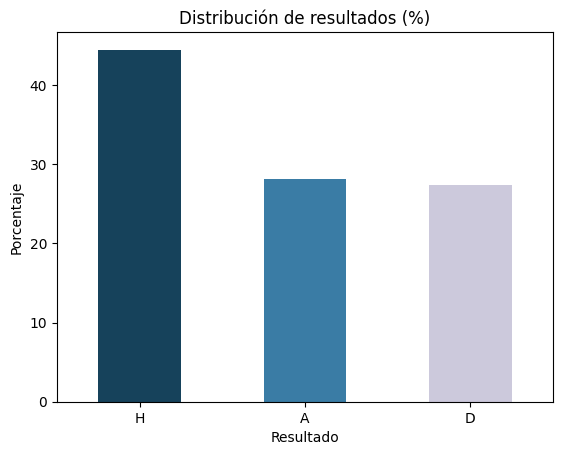

In [19]:
# Conteo de la frecuencia de victorias dependiendo de ser local o visitante
result_dist = ligaMx_unido['result'].value_counts(normalize=True) * 100
print()
print(result_dist.round(2))

# Colores según el resultado
colors = [dist_colors[result] for result in result_dist.index]

# Gráfico de la distribucion de partidos ganados dependiendo de la localia o visitante
result_dist.plot(
    kind='bar', 
    title = 'Distribución de resultados (%)', 
    ylabel = 'Porcentaje', 
    xlabel = 'Resultado',
    color = colors,
    rot = 0
)

plt.show()

Observaciones:

Antes de entrenar los modelos, analizamos el equilibrio de las clases en nuestro dataset histórico. La distribución de los resultados (Victoria Local, Empate, Victoria Visitante) es el primer indicador del "sesgo natural" del deporte:

**Dominio de la Localía (Home Advantage):** 
Se observa una prevalencia clara de las victorias locales. En la Liga MX, factores como la altitud, el clima y los viajes largos acentúan esta ventaja. Para el modelo, esto establece un prior estadístico: la probabilidad base de una victoria local es superior a las demás.

**Fenómeno del Empate (Draw):**
 El empate suele ser la clase menos frecuente, pero la más difícil de predecir. Su distribución nos indica que el modelo necesitará características muy específicas (como solidez defensiva u objetivos de puntos en torneos cortos) para no subestimar esta probabilidad.

**Implicaciones para el Modelo:** Dado que las clases no están perfectamente equilibradas, el uso de la Exactitud (Accuracy) sería engañoso. Por ello, nuestra métrica principal será el Log Loss, que penaliza las predicciones seguras pero incorrectas, obligando al modelo a estar bien calibrado.

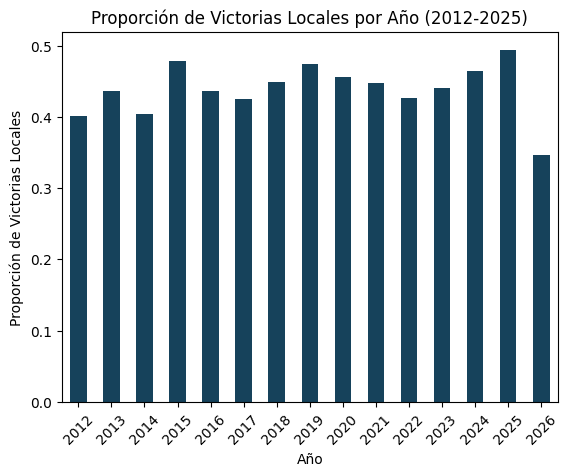

In [20]:
# Agrupación de Victorias locales por año
ligaMx_unido.groupby('year')['result'].value_counts(normalize=True).unstack()['H'].round(3).plot(kind='bar', color=dist_colors['H'])

# Gráfica
plt.title('Proporción de Victorias Locales por Año (2012-2025)')
plt.xlabel('Año')
plt.ylabel('Proporción de Victorias Locales')
plt.xticks(rotation=45)
plt.show()

Observaciones:

**Sesgo Sistémico:** 
La victoria local no solo es el resultado más frecuente (~44.5%), sino que se mantiene sorprendentemente estable a lo largo de más de una década. Esto sugiere que el "Efecto Estadio" en la Liga MX es un factor estructural y no circunstancial.

**Equilibrio de la Oposición:** 
El hecho de que el empate (D) y la victoria visitante (A) compartan una proporción casi idéntica refuerza la dificultad de ganar fuera de casa. Para el modelo de Machine Learning, esto significa que predecir un resultado distinto a "Local" requiere señales de "forma reciente" muy potentes para compensar la probabilidad base.

**4.2** `Resultados por equipo`

¿La distribución de resultados cambia entre equipos cuando juegan en casa?

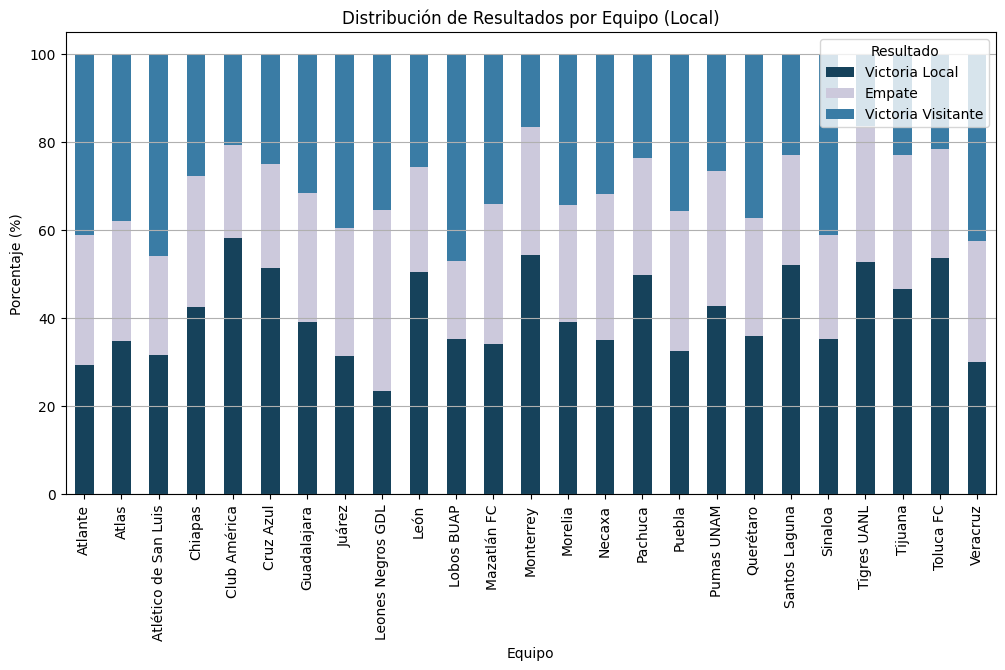

In [21]:
team_results = ligaMx_unido.groupby('home_team')['result'].value_counts(normalize=True).unstack().fillna(0) * 100
team_results = team_results[['H', 'D', 'A']]  # Asegurar el orden H, D, A
team_results.head()
team_results.plot(
    kind='bar', 
    stacked=True, 
    figsize=(12, 6),
    title='Distribución de Resultados por Equipo (Local)',
    color=[dist_colors['H'], dist_colors['D'], dist_colors['A']]
)   
plt.ylabel('Porcentaje (%)')
plt.xlabel('Equipo')
plt.legend(title='Resultado', loc='upper right', labels=['Victoria Local', 'Empate', 'Victoria Visitante'])
plt.grid(axis='y')
plt.show()


La gráfica responde a esta pregunta:

**“Cuando este equipo juega como local, ¿qué porcentaje de las veces gana, empata o pierde?”**
1. Fortaleza como local **Equipos con una sección Victoria Local (H) grande:**

- Aprovechan bien la localía
- Tienen alto rendimiento en casa

2. Vulnerabilidad en casa **Equipos con una sección Victoria Visitante (A) grande:**

- Pierden con frecuencia aún siendo locales
- planteles débiles
- Mala adaptación al estadio
- Baja consistencia

3. Tendencia a empatar **Equipos con un bloque Empate (D) grande:**

- Partidos cerrados
- Estrategias conservadoras
- Baja diferencia de goles

**4.3** `Ventaja del local`
 
¿El local anota más goles?

In [22]:
ligaMx_unido[['home_goals', 'away_goals']].describe().round(2)

,home_goals,away_goals
count,4276.00,4276.00
mean,1.50,1.15
std,1.22,1.05
min,0.00,0.00
25%,1.00,0.00
50%,1.00,1.00
75%,2.00,2.00
max,9.00,6.00


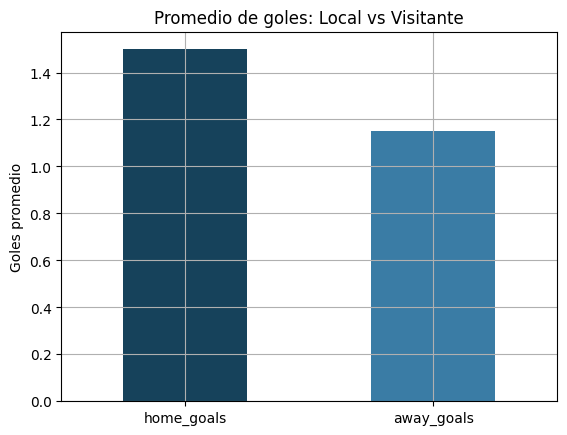

In [23]:
# Visualizacion del Promedio de Goles
ligaMx_unido[['home_goals', 'away_goals']].mean().plot(
    kind='bar', 
    title = 'Promedio de goles: Local vs Visitante', 
    ylabel = 'Goles promedio',
    color = colors,
    rot = 0
)

plt.grid()
plt.show()

Observaciones:

**Superioridad Ofensiva:**
 Existe una ventaja clara en la producción de goles cuando se juega como local (1.5 goles) frente al visitante (1.1 goles).


**4.4** `Coherencia de Goles vs Resultado`

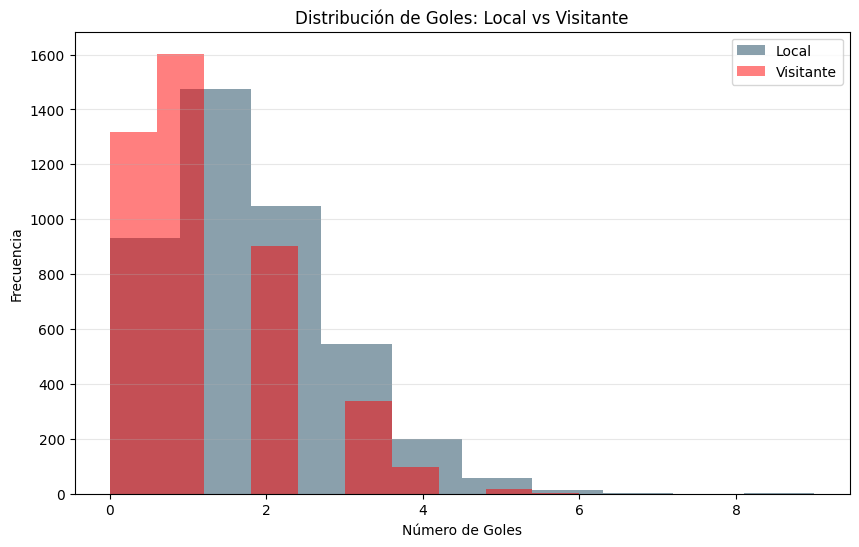

In [24]:
# Configuramos el tamaño de la imagen 
plt.figure(figsize=(10, 6))

# Grafica de ambos histogramas
ligaMx_unido['home_goals'].plot(kind='hist', bins=10, alpha=0.5, label='Local', color="#16425b")
ligaMx_unido['away_goals'].plot(kind='hist', bins=10, alpha=0.5, label='Visitante', color='red')

# Personalización
plt.title('Distribución de Goles: Local vs Visitante')
plt.xlabel('Número de Goles')
plt.ylabel('Frecuencia')
plt.legend(loc='upper right') # Muestra los nombres de las etiquetas
plt.grid(axis='y', alpha=0.3) # Una cuadrícula suave para facilitar la lectura

plt.show()

Observaciones: 

La frecuencia de goles locales (H) se desplaza hacia la derecha del eje X con mayor volumen que la visitante, confirmando que el techo ofensivo es más alto en casa. Esto valida el uso de la localía como un fuerte predictor lineal.

4.5 `Evolución temporal`

¿El fútbol cambia estructuralmente con el tiempo?

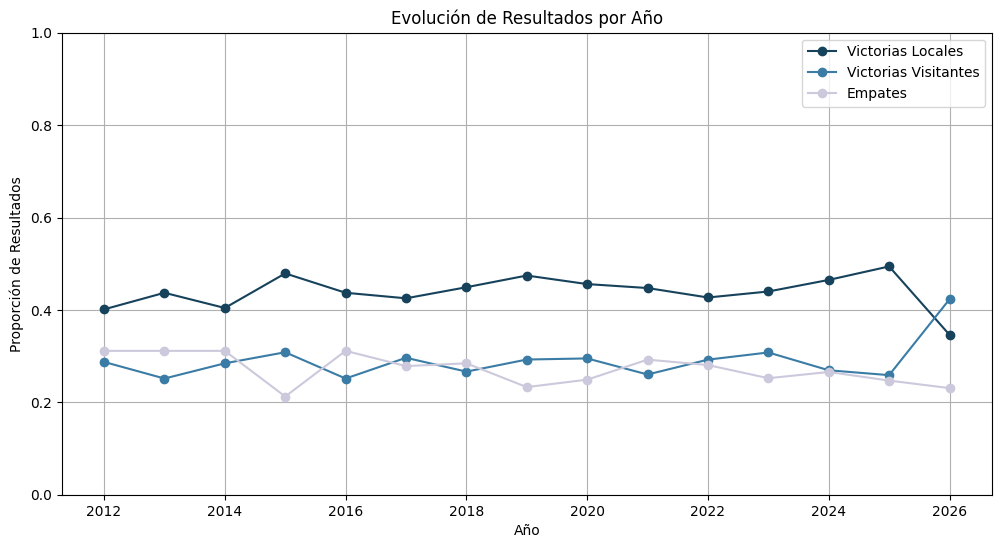

In [25]:
# cálculo de proporciones por año de victorias locales, empates y victorias visitantes
matches_evo = (
    ligaMx_unido
    .groupby('year')['result']
    .value_counts(normalize=True)
    .rename('proportion')
    .reset_index()
)

#Filtra el DataFrame donde las filas según el resultad
home_trend = matches_evo[matches_evo['result'] == 'H']
away_trend = matches_evo[matches_evo['result'] == 'A']
draw_trend = matches_evo[matches_evo['result'] == 'D']

# Visualización Eje X: los años, Eje Y: proporción de resultados
plt.figure(figsize=(12, 6))
plt.plot(home_trend['year'], home_trend['proportion'], marker='o', label='Victorias Locales', color=dist_colors['H'])
plt.plot(away_trend['year'], away_trend['proportion'], marker='o', label='Victorias Visitantes', color=dist_colors['A'])
plt.plot(draw_trend['year'], draw_trend['proportion'], marker='o', label='Empates', color=dist_colors['D'])
plt.title('Evolución de Resultados por Año')
plt.xlabel('Año')
plt.ylabel('Proporción de Resultados')
plt.ylim(0, 1)
plt.legend()
plt.grid()
plt.show()

Observaciones:

**Dominancia Persistente:** La victoria local (H) no solo es el resultado más frecuente, sino que muestra una estabilidad notable, situándose generalmente por encima del 40%.

**Paralelismo entre Visitantes y Empates:** Es interesante observar cómo las líneas de Away y Draw suelen "competir" por el segundo lugar, manteniéndose en rangos muy similares (cercanos al 25-30%), lo que refuerza la idea de que para el visitante es casi tan difícil empatar como ganar.

**
Sin Cambios Estructurales Drásticos:** La ausencia de cruces constantes entre las líneas sugiere que las reglas fundamentales del éxito en la liga (ganar en casa) no han cambiado en más de una década.

4.6 `Tendencia de goles por año`

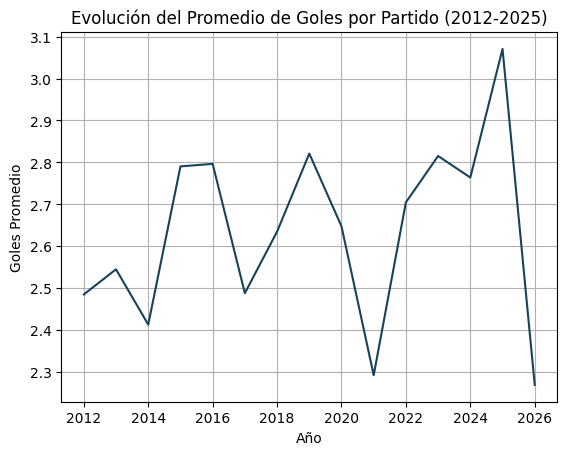

In [26]:
# Columna con el número total de goles por partido
ligaMx_unido['total_goals'] = ligaMx_unido['home_goals'] + ligaMx_unido['away_goals']

# Gráfica
ligaMx_unido.groupby('year')['total_goals'].mean().plot(color='#16425b')
plt.title('Evolución del Promedio de Goles por Partido (2012-2025)')
plt.xlabel('Año')
plt.ylabel('Goles Promedio')
plt.grid()
plt.show()

Observaciones:

**"Efecto Pandemia":** Los datos muestran una caída pronunciada en el promedio de goles entre 2020 y 2021. Al no haber público en las gradas, la presión ambiental desapareció, lo que sugiere que el apoyo de la afición en la Liga MX es un motor real de agresividad ofensiva.

**Ruptura de la Media Histórica (Post-2024):** Es muy relevante que a partir de 2024 la línea cruce de forma ascendente la media de los últimos 12 años. Esto indica que la liga está entrando en una fase de mayor eficacia goleadora, superando los niveles de la década pasada.

**Estabilidad vs. Volatilidad:** 
Antes de 2020, la producción de goles se mantenía orbitando cerca de la media. El comportamiento reciente (la caída y el repunte agresivo) sugiere que factores externos (cambios de formato, reglas de extranjeros o el fin de la pandemia) han inyectado volatilidad al promedio de anotaciones.

# 5. Feature Engineering

En esta fase, transformamos el dataset crudo en una estructura de formato largo (un equipo por fila). El objetivo es que cada registro represente la situación de un equipo específico antes de iniciar un encuentro.

Principios de Diseño Predictivo
Para garantizar la integridad del modelo y evitar el Data Leakage, aplicamos los siguientes criterios:

- **Perspectiva Temporal:** Solo se utiliza información disponible antes del partido.
- **Aislamiento de Registros:** No se incluyen estadísticas del partido en curso dentro de sus propios predictores.
- **Estadísticas Dinámicas:** En lugar de promedios globales, utilizamos cálculos Rolling (ventanas móviles) para capturar la "forma" o racha actual del equipo.
- **Consistencia de Identidad:** Todos los cálculos se realizan agrupando por equipo, asegurando que la historia de un club no se mezcle con la de otro.

In [27]:
# Asegurar orden cronológico
features = ligaMx_unido.copy()
features = features.sort_values('date').reset_index(drop=True)

# Creación de columna Año
features['year'] = features['date'].dt.year

features.head()

,date,time,home_team,away_team,home_goals,away_goals,result,year,total_goals
0,2012-01-09,01:30:00,Tijuana,Chiapas,2.0,0.0,H,2012,2.0
1,2012-01-09,03:30:00,Morelia,Pumas UNAM,0.0,1.0,A,2012,1.0
2,2012-01-09,23:00:00,Cruz Azul,Pachuca,1.0,1.0,D,2012,2.0
3,2012-01-09,23:00:00,Querétaro,Atlante,0.0,1.0,A,2012,1.0
4,2012-01-10,00:00:00,Atlante,Santos Laguna,1.0,3.0,A,2012,4.0


## 5.1 Creación de Rolling Windows (ventanas Móviles)

Se usan rolling features: Porque permiten capturar la forma reciente de los equipos sin introducir fuga de información, usando únicamente ventanas móviles de partidos anteriores.

Rolling vs histórico (comparación clave)
| Método | Problema |
|--------|----------|
| Promedio histórico | No cambia |
| Rolling | Evoluciona |
| Último partido | Muy ruidoso |
| Rolling 5 | Balance óptimo | 

Por eso usamos 5 partidos.

**Rolling de goles (forma ofensiva y defensiva)**

Objetivo:
- Transformar información cruda en ventajas comparativas entre local y visitante, sin fuga de información.

Interpretación:
- goals_for_5 --> capacidad ofensiva reciente.
- goals_against_5 --> solidez defensiva reciente.
- goal_diff_ 5 --> equipos que anotan más de lo que conceden.

**Estas variables asumen que la forma reciente es más informativa que la histórica.**

5.1.1 `Rolling de Local o Visitante`

In [28]:
# Dataset de equpo Local (Home)
home_matches = features[['date', 'home_team', 'home_goals', 'away_goals']] \
    .rename(columns={
        'home_team': 'team',
        'home_goals': 'goals_for',
        'away_goals': 'goals_against'
    })

# Dataset de equipo Visitante (Away)
away_matches = features[['date', 'away_team', 'away_goals', 'home_goals']] \
    .rename(columns={
        'away_team': 'team',
        'away_goals': 'goals_for',
        'home_goals': 'goals_against'
    })

# Unión de abmos datasets
long_matches = pd.concat([home_matches, away_matches], axis=0)
long_matches = long_matches.sort_values('date').reset_index(drop=True)
long_matches.head()

,date,team,goals_for,goals_against
0,2012-01-09,Tijuana,2.0,0.0
1,2012-01-09,Chiapas,0.0,2.0
2,2012-01-09,Pumas UNAM,1.0,0.0
3,2012-01-09,Atlante,1.0,0.0
4,2012-01-09,Pachuca,1.0,1.0


In [29]:
# Cálculo de puntos
long_matches['points'] = np.where(
    long_matches['goals_for'] > long_matches['goals_against'], 3,
    np.where(long_matches['goals_for'] < long_matches['goals_against'], 0, 1)
)

long_matches.head()

,date,team,goals_for,goals_against,points
0,2012-01-09,Tijuana,2.0,0.0,3
1,2012-01-09,Chiapas,0.0,2.0,0
2,2012-01-09,Pumas UNAM,1.0,0.0,3
3,2012-01-09,Atlante,1.0,0.0,3
4,2012-01-09,Pachuca,1.0,1.0,1


Los equipos no son estáticos, queremos capturar cómo llegan al partido.

Para el enfoque de ultimos 5 partidos se asignan puntos a cada equipo en base al resultado del encuentro

Puntaje:
- Victoria = 3
- Empate = 1
- Derrota = 0

5.1.2 `Protocolo de Integridad Temporal` (Anti-Leakage)
Para garantizar que el modelo sea realista, se ha aplicado un **desplazamiento temporal (`.shift(1)`)** en el cálculo de todas las variables de rendimiento (*rolling stats*). 

Esto asegura que para predecir un partido en la fecha **T**, el sistema solo utilice información disponible en **T-1**. De esta forma, evitamos que el modelo "vea el futuro" y garantizamos que las métricas de evaluación sean honestas y aplicables en el mundo real.

In [30]:
# Creacion del Rolling
## groupby analiza cada equipo por separado
## rolling () windows=5 ---> usa solo los ultimos 5 partidos
##            min_periods= 1 ---> permite calcular desde el primer partido
## mean() calcula el promedio de puntos en esa ventana
## shift (1) Usa solo partidos anteriores al actual

# Calcular promedio de puntos en los últimos 5 partidos
long_matches['form_5'] = (
    long_matches
    .groupby('team')['points']
    .rolling(window=5, min_periods=1)
    .mean()
    .shift(1)
    .reset_index(level=0, drop=True)
)

long_matches[['team', 'date', 'points', 'form_5']].head(10)

,team,date,points,form_5
0,Tijuana,2012-01-09,3,1.4
1,Chiapas,2012-01-09,0,0.8
2,Pumas UNAM,2012-01-09,3,0.6
3,Atlante,2012-01-09,3,NaN
4,Pachuca,2012-01-09,1,1.4
5,Morelia,2012-01-09,0,1.8
6,Cruz Azul,2012-01-09,1,0.8
7,Querétaro,2012-01-09,0,1.6
8,Atlante,2012-01-10,0,3.0
9,Santos Laguna,2012-01-10,3,1.4


**La clave de un modelo predictivo robusto es asegurar que no exista "fuga de información" del futuro.** Para ello, implementamos una transformación mediante la función .shift(1) tras el cálculo de las medias móviles.

¿Qué logramos con este protocolo?

- Desplazamiento Predictivo: Al aplicar el shift, el registro del partido de la jornada 10, por ejemplo, contiene únicamente el promedio de rendimiento de las jornadas 5 a la 9.
- Simulación de Realidad: El modelo se ve obligado a decidir basándose exclusivamente en la "Foto del Pasado", tal como lo haría un analista o un apostador minutos antes de que empiece el encuentro.
- Eliminación de Sesgos: Evitamos que el promedio móvil "se contamine" con los goles que el equipo está por anotar en el partido que intentamos predecir.

In [31]:
# Goles a favor (últimos 5 partidos)
long_matches['goals_for_5'] = (
    long_matches
    .groupby('team')['goals_for']
    .rolling(window=5, min_periods=1)
    .mean()
    .shift(1)
    .reset_index(level=0, drop=True)
)

# Goles en contra (últimos 5 partidos)
long_matches['goals_against_5'] = (
    long_matches
    .groupby('team')['goals_against']
    .rolling(window=5, min_periods=1)
    .mean()
    .shift(1)
    .reset_index(level=0, drop=True)
)

# Diferencial de goles (forma neta)
long_matches['goal_diff_5'] = (
    long_matches['goals_for_5'] - long_matches['goals_against_5']
)

long_matches.head()

,date,team,goals_for,goals_against,points,form_5,goals_for_5,goals_against_5,goal_diff_5
0,2012-01-09,Tijuana,2.0,0.0,3,1.4,0.8,1.0,-0.2
1,2012-01-09,Chiapas,0.0,2.0,0,0.8,1.2,1.6,-0.4
2,2012-01-09,Pumas UNAM,1.0,0.0,3,0.6,0.6,1.6,-1.0
3,2012-01-09,Atlante,1.0,0.0,3,NaN,NaN,NaN,NaN
4,2012-01-09,Pachuca,1.0,1.0,1,1.4,1.6,1.2,0.4


5.1.3 `Ranking Histórico`

In [32]:
# Cálculo de estadísticas históricas por equipo
ranking_historico = long_matches.groupby('team').agg({
    'points': ['sum', 'count'],
    'goals_for': 'sum',
    'goals_against': 'sum'
}).reset_index()

# Aplanamos el MultiIndex de las columnas
ranking_historico.columns = ['team', 'total_pts', 'total_matches', 'total_gf', 'total_ga']

# Cálculo de métricas de eficiencia global
ranking_historico['win_rate'] = ranking_historico['total_pts'] / (ranking_historico['total_matches'] * 3)
ranking_historico['avg_goal_diff'] = (ranking_historico['total_gf'] - ranking_historico['total_ga']) / ranking_historico['total_matches']

# Uni´n de la capacidad de sumar puntos con la contundencia (goles)
ranking_historico['dominance_index'] = (ranking_historico['win_rate'] * 0.6) + (ranking_historico['avg_goal_diff'] * 0.4)

# Tiers (1: Elite, 2: Media, 3: Baja)
# Uso de rank para asegurar que no haya problemas con valores idénticos
ranking_historico['team_tier'] = pd.qcut(ranking_historico['dominance_index'].rank(method='first'), 3, labels=[3, 2, 1]).astype(int)

# Creación del diccionario para mapear al dataframe final
tier_map = ranking_historico.set_index('team')['team_tier'].to_dict()


Observaciones:

No todos los equipos entran al campo con el mismo peso histórico. Mientras que las ventanas móviles capturan el "momento", el Ranking Histórico permite al modelo entender la jerarquía a largo plazo de cada institución.

Lógica del Indicador:
- Estabilidad de Datos: Se calcula el promedio de puntos obtenidos por cada equipo en todo el dataset. Esto diferencia a los equipos "contendientes" constantes de aquellos que suelen estar en la parte baja de la tabla.
- Factor de Corrección: Esta variable actuará como un ancla para el modelo. Si un equipo grande tiene una mala racha (ventana móvil baja), el Ranking Histórico le recordará al modelo que su capacidad de reacción es estadísticamente superior a la de un equipo pequeño en la misma situación.

$Tiers (1: Elite, 2: Media, 3: Baja)$

**Normalización de Contexto:** 
Al asignar un valor numérico de jerarquía, el modelo puede ponderar si una victoria reciente fue contra un rival de alto o bajo calibre.

5.1.4 `Separar features local y visitante`

Las features calculadas por equipo se integran nuevamente al dataset de partidos, diferenciando explícitamente entre equipo local y visitante.

In [33]:
home_features = long_matches.rename(columns=lambda x: f'home_{x}')
away_features = long_matches.rename(columns=lambda x: f'away_{x}')

## Verificación de Data Leakage y Consistencia Temporal

En problemas de predicción deportiva, uno de los riesgos metodológicos más críticos es la fuga de información (data leakage), que ocurre cuando el modelo utiliza datos que no estarían disponibles en el momento real de la predicción. En el contexto del fútbol, este problema suele aparecer al calcular estadísticas históricas que, de forma inadvertida, incluyen información del partido que se intenta predecir.

Para mitigar este riesgo, el proceso de feature engineering se diseñó explícitamente para respetar la estructura temporal de los datos y simular un escenario realista de predicción previa al partido. En particular, todas las variables basadas en rendimiento histórico (forma reciente, goles a favor, goles en contra y diferenciales) se calcularon siguiendo los principios descritos a continuación:

Los partidos fueron ordenados cronológicamente por fecha antes de cualquier cálculo de agregación.

Las estadísticas se calcularon en un formato longitudinal (long format), donde cada fila representa el historial temporal de un equipo en partidos consecutivos, independientemente de si actuó como local o visitante.

Las métricas de forma y rendimiento reciente se calcularon mediante ventanas móviles (rolling windows) agrupadas por equipo (groupby('team')).

Todas las variables rolling fueron desplazadas temporalmente mediante shift(1), garantizando que, para cada partido, las características del equipo se basan exclusivamente en información de encuentros anteriores y excluyen explícitamente el partido actual.

Este desplazamiento temporal asegura que el modelo no tenga acceso a resultados futuros ni contemporáneos al evento que se intenta predecir. Como consecuencia, las métricas de evaluación obtenidas reflejan un escenario válido y consistente desde el punto de vista estadístico, alineado con un uso real del modelo en predicción prospectiva de partidos.

5.1.5 `Merge con el dataset de partidos`

asignación a cada partido:
- forma reciente del local
- forma reciente del visitante

In [34]:
# Creación del dataset final para el modelado
# Unión con home_features
matches_model = features.merge(
    home_features,
    left_on=['date', 'home_team'],
    right_on=['home_date', 'home_team'],
    how='left'
)
# Unión con away_features
matches_model = matches_model.merge(
    away_features,
    left_on=['date', 'away_team'],
    right_on=['away_date', 'away_team'],
    how='left'
)

matches_model.head().round(4)

,date,time,home_team,away_team,home_goals,away_goals,result,year,total_goals,home_date,...,home_goals_against_5,home_goal_diff_5,away_date,away_goals_for,away_goals_against,away_points,away_form_5,away_goals_for_5,away_goals_against_5,away_goal_diff_5
0,2012-01-09,01:30:00,Tijuana,Chiapas,2.0,0.0,H,2012,2.0,2012-01-09,...,1.0,-0.2,2012-01-09,0.0,2.0,0,0.8,1.2,1.6,-0.4
1,2012-01-09,03:30:00,Morelia,Pumas UNAM,0.0,1.0,A,2012,1.0,2012-01-09,...,1.0,1.0,2012-01-09,1.0,0.0,3,0.6,0.6,1.6,-1.0
2,2012-01-09,23:00:00,Cruz Azul,Pachuca,1.0,1.0,D,2012,2.0,2012-01-09,...,1.4,-1.0,2012-01-09,1.0,1.0,1,1.4,1.6,1.2,0.4
3,2012-01-09,23:00:00,Querétaro,Atlante,0.0,1.0,A,2012,1.0,2012-01-09,...,1.4,0.0,2012-01-09,1.0,0.0,3,NaN,NaN,NaN,NaN
4,2012-01-10,00:00:00,Atlante,Santos Laguna,1.0,3.0,A,2012,4.0,2012-01-10,...,0.0,1.0,2012-01-10,3.0,1.0,3,1.4,1.2,1.2,0.0


In [35]:
# Mapeo de la jerarquía histórica a los equipos del partido
matches_model['home_tier'] = matches_model['home_team'].map(tier_map)
matches_model['away_tier'] = matches_model['away_team'].map(tier_map)

# Creación de la variable de 'Diferencia de Jerarquía'
# Si es +2, el local es Tier 1 (Elite) y el visitante Tier 3 (Bajo) -> Gran ventaja local
matches_model['diff_tier'] = matches_model['away_tier'].astype(int) - matches_model['home_tier'].astype(int)
matches_model.head()

,date,time,home_team,away_team,home_goals,away_goals,result,year,total_goals,home_date,...,away_goals_for,away_goals_against,away_points,away_form_5,away_goals_for_5,away_goals_against_5,away_goal_diff_5,home_tier,away_tier,diff_tier
0,2012-01-09,01:30:00,Tijuana,Chiapas,2.0,0.0,H,2012,2.0,2012-01-09,...,0.0,2.0,0,0.8,1.2,1.6,-0.4,2,2,0
1,2012-01-09,03:30:00,Morelia,Pumas UNAM,0.0,1.0,A,2012,1.0,2012-01-09,...,1.0,0.0,3,0.6,0.6,1.6,-1.0,2,2,0
2,2012-01-09,23:00:00,Cruz Azul,Pachuca,1.0,1.0,D,2012,2.0,2012-01-09,...,1.0,1.0,1,1.4,1.6,1.2,0.4,1,1,0
3,2012-01-09,23:00:00,Querétaro,Atlante,0.0,1.0,A,2012,1.0,2012-01-09,...,1.0,0.0,3,NaN,NaN,NaN,NaN,2,3,1
4,2012-01-10,00:00:00,Atlante,Santos Laguna,1.0,3.0,A,2012,4.0,2012-01-10,...,3.0,1.0,3,1.4,1.2,1.2,0.0,3,1,-2


Observaciones:
- Valores negativos favorecen al local
- Positivos al visitante

5.1.6 `Variables de diferencia` 

Los modelos no piensan en absolutos, piensan en comparaciones.

El modelo se alimenta de diferencias entre local y visitante, ya que el resultado de un partido depende de la ventaja relativa entre ambos equipos, no de valores absolutos.

In [36]:
# Diferencia de forma
matches_model['diff_form_5'] = (
    matches_model['home_form_5'] - matches_model['away_form_5']
)

# Diferencia ofensiva
matches_model['diff_goals_for_5'] = (
    matches_model['home_goals_for_5'] - matches_model['away_goals_for_5']
)

# Diferencia defensiva
matches_model['diff_goals_against_5'] = (
    matches_model['home_goals_against_5'] - matches_model['away_goals_against_5']
)

5.2 `Ajuste del Dataset y Tratamiento de Nulos`

Tras la creación de variables dinámicas, es necesario realizar una limpieza técnica para asegurar la calidad de las muestras que entrarán al modelo.

Origen de los valores nulos: Al utilizar una ventana móvil de 5 partidos, los primeros 5 encuentros de cada equipo en el dataset histórico no cuentan con suficiente información previa para calcular un promedio. Esto genera valores NaN (Not a Number).

**Protocolo de Limpieza:**

- **Auditoría de Nulos:** Se utiliza la función fun_null para cuantificar el impacto de las variables móviles en la integridad del dataset.
- **Poda Selectiva:** En lugar de imputar datos (lo cual inventaría información inexistente), optamos por eliminar estas filas iniciales. Esto garantiza que el modelo solo aprenda de partidos donde existe un historial de forma reciente plenamente documentado.

In [37]:
# Funcion para conteo de valores nulos por columna y porcentaje
def fun_null (df):
    null_count = df.isnull().sum()
    null_percentage = (null_count / len(df)) * 100
    null_df = pd.DataFrame({'Null Count': null_count, 'Null Percentage': null_percentage})
    return null_df

In [38]:
print(" === valores nulos en matches_model ===")
print(fun_null(matches_model).round(2))
print()

 === valores nulos en matches_model ===
                      Null Count  Null Percentage
date                           0             0.00
time                           9             0.21
home_team                      0             0.00
away_team                      0             0.00
home_goals                     0             0.00
away_goals                     0             0.00
result                         0             0.00
year                           0             0.00
total_goals                    0             0.00
home_date                      0             0.00
home_goals_for                 0             0.00
home_goals_against             0             0.00
home_points                    0             0.00
home_form_5                    0             0.00
home_goals_for_5               0             0.00
home_goals_against_5           0             0.00
home_goal_diff_5               0             0.00
away_date                      0             0.00
away_goals

In [39]:
matches_model = matches_model.dropna().reset_index(drop=True)
matches_model.head().round(3)

,date,time,home_team,away_team,home_goals,away_goals,result,year,total_goals,home_date,...,away_form_5,away_goals_for_5,away_goals_against_5,away_goal_diff_5,home_tier,away_tier,diff_tier,diff_form_5,diff_goals_for_5,diff_goals_against_5
0,2012-01-09,01:30:00,Tijuana,Chiapas,2.0,0.0,H,2012,2.0,2012-01-09,...,0.8,1.2,1.6,-0.4,2,2,0,0.6,-0.4,-0.6
1,2012-01-09,03:30:00,Morelia,Pumas UNAM,0.0,1.0,A,2012,1.0,2012-01-09,...,0.6,0.6,1.6,-1.0,2,2,0,1.2,1.4,-0.6
2,2012-01-09,23:00:00,Cruz Azul,Pachuca,1.0,1.0,D,2012,2.0,2012-01-09,...,1.4,1.6,1.2,0.4,1,1,0,-0.6,-1.2,0.2
3,2012-01-10,00:00:00,Atlante,Santos Laguna,1.0,3.0,A,2012,4.0,2012-01-10,...,1.4,1.2,1.2,0.0,3,1,-2,1.6,-0.2,-1.2
4,2012-02-09,01:00:00,Monterrey,Atlas,1.0,1.0,D,2012,2.0,2012-02-09,...,0.8,1.4,2.2,-0.8,1,2,1,0.0,-0.4,-0.2


In [40]:
print(" === valores nulos en matches_model ===")
print(fun_null(matches_model).round(2))
print()

 === valores nulos en matches_model ===
                      Null Count  Null Percentage
date                           0              0.0
time                           0              0.0
home_team                      0              0.0
away_team                      0              0.0
home_goals                     0              0.0
away_goals                     0              0.0
result                         0              0.0
year                           0              0.0
total_goals                    0              0.0
home_date                      0              0.0
home_goals_for                 0              0.0
home_goals_against             0              0.0
home_points                    0              0.0
home_form_5                    0              0.0
home_goals_for_5               0              0.0
home_goals_against_5           0              0.0
home_goal_diff_5               0              0.0
away_date                      0              0.0
away_goals

In [41]:
print(matches_model.head())

        date      time  home_team      away_team  home_goals  away_goals  \
0 2012-01-09  01:30:00    Tijuana        Chiapas         2.0         0.0   
1 2012-01-09  03:30:00    Morelia     Pumas UNAM         0.0         1.0   
2 2012-01-09  23:00:00  Cruz Azul        Pachuca         1.0         1.0   
3 2012-01-10  00:00:00    Atlante  Santos Laguna         1.0         3.0   
4 2012-02-09  01:00:00  Monterrey          Atlas         1.0         1.0   

  result  year  total_goals  home_date  ...  away_form_5  away_goals_for_5  \
0      H  2012          2.0 2012-01-09  ...          0.8               1.2   
1      A  2012          1.0 2012-01-09  ...          0.6               0.6   
2      D  2012          2.0 2012-01-09  ...          1.4               1.6   
3      A  2012          4.0 2012-01-10  ...          1.4               1.2   
4      D  2012          2.0 2012-02-09  ...          0.8               1.4   

   away_goals_against_5  away_goal_diff_5  home_tier  away_tier  diff_tier

In [42]:
matches_model.columns

Index(['date', 'time', 'home_team', 'away_team', 'home_goals', 'away_goals',
       'result', 'year', 'total_goals', 'home_date', 'home_goals_for',
       'home_goals_against', 'home_points', 'home_form_5', 'home_goals_for_5',
       'home_goals_against_5', 'home_goal_diff_5', 'away_date',
       'away_goals_for', 'away_goals_against', 'away_points', 'away_form_5',
       'away_goals_for_5', 'away_goals_against_5', 'away_goal_diff_5',
       'home_tier', 'away_tier', 'diff_tier', 'diff_form_5',
       'diff_goals_for_5', 'diff_goals_against_5'],
      dtype='object')

Guarda modelo despues de actualizar

matches_model.to_csv(
    "data/matches_model.csv",
    index=False
)

# Entrenamiento y Selección de Modelos

En las siguientes etapas, enfrentamos dos filosofías algorítmicas distintas para determinar cuál captura mejor la naturaleza del fútbol mexicano: la simplicidad lineal contra la complejidad de los árboles de decisión.

**Configuración del Experimento**
- **Target:** columna 'result' (0: Visitante, 1: Empate, 2: Local).
- **Predictores:** Variables dinámicas de forma reciente (goles, tiros, resultados pasados) y la jerarquía institucional (Ranking).

**Métrica Maestra (Log Loss):** A diferencia del Accuracy (que solo dice si el modelo acertó), el Log Loss penaliza la falta de confianza. Buscamos un modelo que no solo "adivine", sino que asigne probabilidades realistas a cada evento.

`El split anual introduce un pequeño ruido estructural (Apertura/Clausura), aceptado para priorizar independencia temporal`

**Definición de Modelos**
- **Regresión Logística (Baseline):** 
Elegido por su capacidad de manejar relaciones lineales y su facilidad de interpretación. Es el estándar de oro para problemas donde los factores de éxito son aditivos.

- **XGBoost (Gradient Boosting):** 
Elegido para detectar interacciones no lineales complejas entre las variables (por ejemplo, cómo influye una mala racha de goles específicamente contra un rival con alto ranking).

# 6. Modelo base: Logistic Regression 
(modelo lineal)

In [43]:
# Define temporal cutoff date 
cutoff_date = '2025-01-01'

# Definir dos datasets de entrenamiento 2012-2024 y prueba 2025 
train_data = matches_model[matches_model['date'] < cutoff_date] # Antes de la temporada pasada]
test_data = matches_model[matches_model['date'] >= cutoff_date] # Inicio de la temporada pasada]

print('Las dimensiones del dataset de entrenamiento son:', train_data.shape)
print('Las dimensiones del dataset de prueba son:', test_data.shape)

Las dimensiones del dataset de entrenamiento son: (4070, 31)
Las dimensiones del dataset de prueba son: (196, 31)


In [44]:
train_data.columns

Index(['date', 'time', 'home_team', 'away_team', 'home_goals', 'away_goals',
       'result', 'year', 'total_goals', 'home_date', 'home_goals_for',
       'home_goals_against', 'home_points', 'home_form_5', 'home_goals_for_5',
       'home_goals_against_5', 'home_goal_diff_5', 'away_date',
       'away_goals_for', 'away_goals_against', 'away_points', 'away_form_5',
       'away_goals_for_5', 'away_goals_against_5', 'away_goal_diff_5',
       'home_tier', 'away_tier', 'diff_tier', 'diff_form_5',
       'diff_goals_for_5', 'diff_goals_against_5'],
      dtype='object')

In [45]:
train_data.head().round(2)

,date,time,home_team,away_team,home_goals,away_goals,result,year,total_goals,home_date,...,away_form_5,away_goals_for_5,away_goals_against_5,away_goal_diff_5,home_tier,away_tier,diff_tier,diff_form_5,diff_goals_for_5,diff_goals_against_5
0,2012-01-09,01:30:00,Tijuana,Chiapas,2.0,0.0,H,2012,2.0,2012-01-09,...,0.8,1.2,1.6,-0.4,2,2,0,0.6,-0.4,-0.6
1,2012-01-09,03:30:00,Morelia,Pumas UNAM,0.0,1.0,A,2012,1.0,2012-01-09,...,0.6,0.6,1.6,-1.0,2,2,0,1.2,1.4,-0.6
2,2012-01-09,23:00:00,Cruz Azul,Pachuca,1.0,1.0,D,2012,2.0,2012-01-09,...,1.4,1.6,1.2,0.4,1,1,0,-0.6,-1.2,0.2
3,2012-01-10,00:00:00,Atlante,Santos Laguna,1.0,3.0,A,2012,4.0,2012-01-10,...,1.4,1.2,1.2,0.0,3,1,-2,1.6,-0.2,-1.2
4,2012-02-09,01:00:00,Monterrey,Atlas,1.0,1.0,D,2012,2.0,2012-02-09,...,0.8,1.4,2.2,-0.8,1,2,1,0.0,-0.4,-0.2


6.1 `Ingenieria de Atributos (features)`

In [46]:
# Atributos (X = features) y objetivo (y = target)
# Variable de atributos para el modelo
features = [
    'diff_tier',
    'diff_form_5',
    'diff_goals_for_5',
    'diff_goals_against_5'
]

# Features y target para entrenamiento
X_train = train_data[features]
y_train = train_data['result']

# Features y target para prueba
X_test = test_data[features]
y_test = test_data['result']


6.2 `Entrenar Logistic Regression`

In [47]:
# Creacion del modelo
logreg_model = LogisticRegression(
    solver='lbfgs',
    max_iter=1000
)

# Entrenamiento del modelo
logreg_model.fit(X_train, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,1000
,multi_class,'deprecated'


6.3 `Matriz de Confusión` del modelo Logistic Regression

In [48]:
# Generar predicciones
y_pred = logreg_model.predict(X_test)

# Matriz de confusion de Logistic Regression
logreg_mc = pd.crosstab(
    y_test, 
    y_pred,
    margins=True 
)

print(logreg_mc)

col_0    A  D    H  All
result                 
A       20  0   35   55
D       16  0   32   48
H        8  1   84   93
All     44  1  151  196


6.4 `Classification report` del modelo Logistic Regression

In [49]:
print(classification_report(y_test, y_pred, digits = 4))

              precision    recall  f1-score   support

           A     0.4545    0.3636    0.4040        55
           D     0.0000    0.0000    0.0000        48
           H     0.5563    0.9032    0.6885        93

    accuracy                         0.5306       196
   macro avg     0.3369    0.4223    0.3642       196
weighted avg     0.3915    0.5306    0.4401       196



In [50]:
# Cálculo de lr_logloss
y_pred_proba = logreg_model.predict_proba(X_test)
lr_logloss = log_loss(y_test, y_pred_proba)
print(f'Logistic Regression Log Loss: {lr_logloss:.4f}')

Logistic Regression Log Loss: 1.0103


Orden de clases: ['A' 'D' 'H']


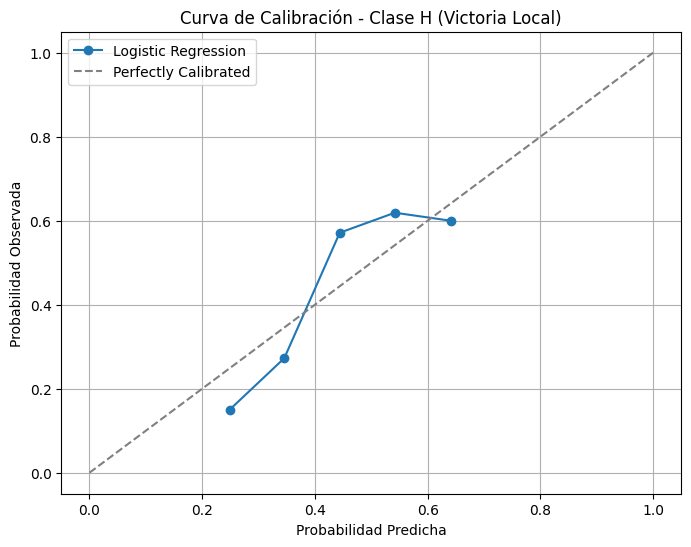

In [51]:
# Curva de calibracion para el modelo de regresio logistica
# 1. Binarizar el target (H vs resto)
y_test_bin = (y_test == 'H').astype(int)

# 2. Verificar el orden de las clases
print('Orden de clases:', logreg_model.classes_)

# 3. Extraer la probabilidad de la clase 'H'
idx_H = list(logreg_model.classes_).index('H')
y_pred_proba_H = y_pred_proba[:, idx_H]

# 4. Calcular curva de calibración
prob_true, prob_pred = calibration_curve(
    y_test_bin,
    y_pred_proba_H,
    n_bins=10
)

# 5. Graficar
plt.figure(figsize=(8, 6))
plt.plot(prob_pred, prob_true, marker='o', label='Logistic Regression')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfectly Calibrated')
plt.title('Curva de Calibración - Clase H (Victoria Local)')
plt.xlabel('Probabilidad Predicha')
plt.ylabel('Probabilidad Observada')
plt.legend()
plt.grid()
plt.show()

In [52]:
calibrated_model = CalibratedClassifierCV(
    logreg_model,
    method='sigmoid',  # o 'sigmoid'
    cv=5
)

calibrated_model.fit(X_train, y_train)

,estimator,LogisticRegre...max_iter=1000)
,method,'sigmoid'
,cv,5
,n_jobs,None
,ensemble,'auto'
,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1


In [53]:
log_loss(y_test, calibrated_model.predict_proba(X_test))

1.012378333794878

6.5 `Baseline probabilístico` 

Si el modelo no supera esto, el modelo no sirve.

In [54]:
baseline_proba = (
    y_train
    .value_counts(normalize=True) # Cuenta cuántos A, D y H hay y los convierte en porcentajes (0 a 1)
    .reindex(logreg_model.classes_) # Ordena las etiquetas (A, D, H) para que coincidan exactamente con el orden que usa el modelo (evita errores de cálculo)
    .values # Extrae solo los números (ej: [0.28, 0.25, 0.47]) y los guarda en un array
)

# Creamos una matriz de predicciones "falsas" para comparar con el modelo real
baseline_pred_proba = np.tile(
    baseline_proba,       # Tomamos nuestro array de probabilidades históricas
    (len(y_test), 1)      # Lo repetimos (lo "tejemos") tantas veces como filas tenga nuestro set de prueba
)

print(baseline_pred_proba)

[[0.28132678 0.27616708 0.44250614]
 [0.28132678 0.27616708 0.44250614]
 [0.28132678 0.27616708 0.44250614]
 [0.28132678 0.27616708 0.44250614]
 [0.28132678 0.27616708 0.44250614]
 [0.28132678 0.27616708 0.44250614]
 [0.28132678 0.27616708 0.44250614]
 [0.28132678 0.27616708 0.44250614]
 [0.28132678 0.27616708 0.44250614]
 [0.28132678 0.27616708 0.44250614]
 [0.28132678 0.27616708 0.44250614]
 [0.28132678 0.27616708 0.44250614]
 [0.28132678 0.27616708 0.44250614]
 [0.28132678 0.27616708 0.44250614]
 [0.28132678 0.27616708 0.44250614]
 [0.28132678 0.27616708 0.44250614]
 [0.28132678 0.27616708 0.44250614]
 [0.28132678 0.27616708 0.44250614]
 [0.28132678 0.27616708 0.44250614]
 [0.28132678 0.27616708 0.44250614]
 [0.28132678 0.27616708 0.44250614]
 [0.28132678 0.27616708 0.44250614]
 [0.28132678 0.27616708 0.44250614]
 [0.28132678 0.27616708 0.44250614]
 [0.28132678 0.27616708 0.44250614]
 [0.28132678 0.27616708 0.44250614]
 [0.28132678 0.27616708 0.44250614]
 [0.28132678 0.27616708 0.44

Observaciones:

Leyendo los valores de izquierda a derecha (según el orden de tus clases ['A', 'D', 'H']):

- 0.2813 (28.1%): Es la probabilidad de que gane el Visitante (Away).
- 0.2761 (27.6%): Es la probabilidad de que haya un Empate (Draw).
- 0.4425 (44.2%): Es la probabilidad de que gane el Local (Home). **--> VENTAJA DE LOCALIA**

Estas probabilidades reflejan la distribución histórica de resultados en el dataset de prueba. Indican que, según el modelo, la victoria del equipo local es el resultado más probable, seguido por la victoria del visitante y finalmente el empate.

6.6 `Log loss del baseline`

In [55]:
# Calculamos el error (Log Loss) comparando la realidad (y_test) contra nuestra predicción "tonta" (baseline_pred_proba)
baseline_logloss = log_loss(y_test, baseline_pred_proba)
# Mostramos el valor resultante en pantalla para tener nuestro punto de referencia
baseline_logloss

1.0578574521994104

`Log Loss` Comparación Modelo vs. Baseline Histórico 'ciego'

Mide calidad de las probabilidades.
**Menor = mejor.**

Observaciones:

El log loss del modelo base es 1.05 y el del modelo de Regresion es de 1.02 refleja que el modelo está capturando patrones útiles en los datos, superando la simple suposición basada en la distribución histórica de resultados. Esto indica que las features seleccionadas y el enfoque de modelado están funcionando adecuadamente para predecir los resultados de los partidos de fútbol.


## Importancia de features (interpretabilidad)
6.7 `Coeficientes del modelo`

In [56]:
coef_logreg = pd.DataFrame(
    logreg_model.coef_,
    columns=features,
    index=logreg_model.classes_
)

coef_logreg.round(4)

,diff_tier,diff_form_5,diff_goals_for_5,diff_goals_against_5
A,-0.2247,0.0903,-0.1009,0.1674
D,-0.0528,-0.0405,-0.0052,-0.1000
H,0.2775,-0.0497,0.1061,-0.0674


Interpretación:

- positivo --> **Favorece la probabilidad de ese resultado**
- negativo --> **Reducen la probabilidad de ese resultado.**

Guardar modelo
joblib.dump(logreg_model, "model/logreg_model.pkl")

## 7. Implementación: Split Temporal + XGBoost

In [57]:
# Inserta esto antes del split de Train/Test
map_res = {'A': 0, 'D': 1, 'H': 2}
matches_model['target'] = matches_model['result'].map(map_res)

# Definir nuestras "Features" (X) y nuestro "Target" (y)
features = [
    # 1. Variables de Diferencia (Señal principal)
    'diff_tier',
    'home_tier',
    'away_tier',
    'diff_form_5', 
    'diff_goals_for_5', 
    'diff_goals_against_5',
    
    # 2. Variables de Balance Individual (Contexto)
    'home_goal_diff_5', 
    'away_goal_diff_5',
]

# Crea una copia de trabajo para no ensuciar matches_final
xgb_model = matches_model.copy()

# Define temporal cutoff date 
cutoff_date = '2025-01-01'

# Definir dos datasets de entrenamiento 2012-2024 y prueba 2025 
xgb_train_data = xgb_model[xgb_model['date'] < cutoff_date] # Antes de la temporada pasada]
xgb_test_data = xgb_model[xgb_model['date'] >= cutoff_date] # Inicio de la temporada pasada]

# Features y target para entrenamiento
X_train = xgb_train_data[features]
y_train = xgb_train_data['target']
# Features y target para prueba
X_test = xgb_test_data[features]
y_test = xgb_test_data['target']

# Modelo
xgb_model = xgb.XGBClassifier(
    objective='multi:softprob', # Importante: Queremos probabilidades, no solo ganador
    n_estimators=100,
    learning_rate=0.01,
    subsample=0.8,
    colsample_bytree=0.8,
    max_depth=3,
    random_state=42
)

#---
# Esto ajusta las probabilidades para que sean más realistas
calibrated_xgb = CalibratedClassifierCV(xgb_model, method='sigmoid', cv=5)
calibrated_xgb.fit(X_train, y_train)
#---

# Entrenamiento del modelo
xgb_model.fit(X_train, y_train)

# Generar predicciones
y_pred = xgb_model.predict(X_test)

In [58]:
# Matriz de confusion de XGBoost
xgb_mc = pd.crosstab(
    y_test, 
    y_pred,
    margins=True 
)

print(xgb_mc)

col_0    0    2  All
target              
0       16   39   55
1       12   36   48
2        6   87   93
All     34  162  196


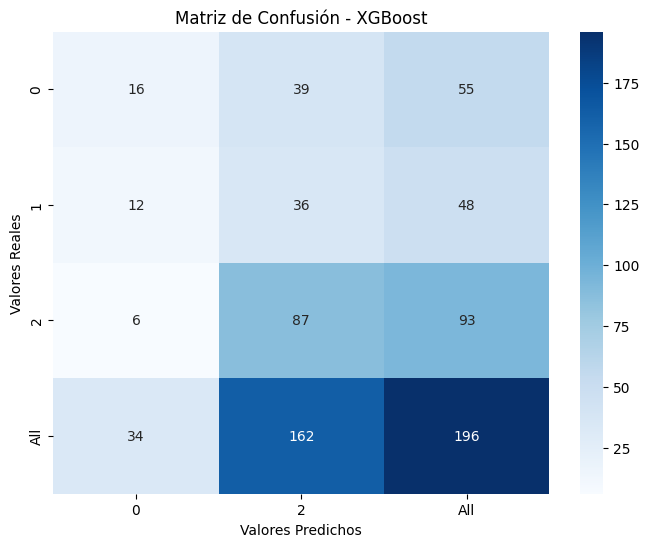

              precision    recall  f1-score   support

           0     0.4706    0.2909    0.3596        55
           1     0.0000    0.0000    0.0000        48
           2     0.5370    0.9355    0.6824        93

    accuracy                         0.5255       196
   macro avg     0.3359    0.4088    0.3473       196
weighted avg     0.3869    0.5255    0.4247       196

XGBoost Log Loss: 1.0145


c:\Users\INSPIRON 15\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\INSPIRON 15\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\INSPIRON 15\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavio

In [59]:
# Grafico # Matriz de confusion de XGBoost
plt.figure(figsize=(8,6))
sns.heatmap(xgb_mc, annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusión - XGBoost')
plt.ylabel('Valores Reales')
plt.xlabel('Valores Predichos')
plt.show()
print(classification_report(y_test, y_pred, digits = 4))

# Cálculo de XGBoost logloss
y_pred_proba = calibrated_xgb.predict_proba(X_test)
xgb_logloss = log_loss(y_test, y_pred_proba)
print(f'XGBoost Log Loss: {xgb_logloss:.4f}')

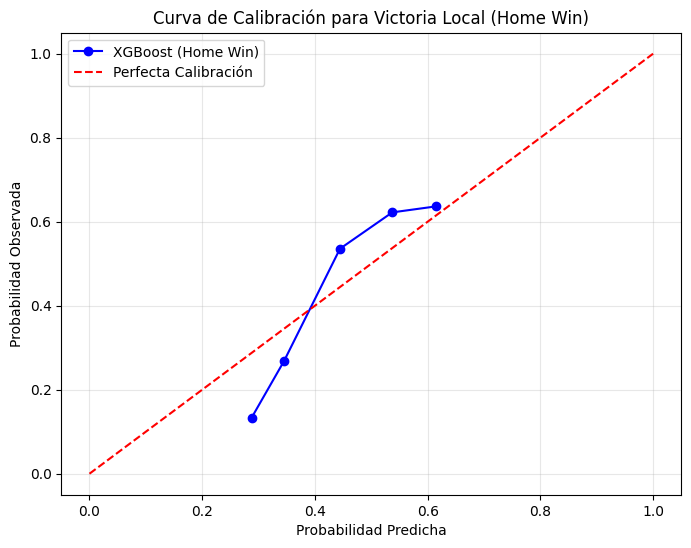

In [60]:
# Extraer probabilidad de victoria local (Home = 'H')
home_class_index = 2  # Índice correspondiente a la clase 'H' (Home Win)
xgb_home_probs = y_pred_proba[:, home_class_index]

# Curva de calibración
prob_true, prob_pred = calibration_curve(
    y_test == home_class_index,
    xgb_home_probs,
    n_bins=10
)

plt.figure(figsize=(8, 6))
plt.plot(prob_pred, prob_true, marker='o', label='XGBoost (Home Win)', color='blue')
plt.plot([0, 1], [0, 1], linestyle='--', label='Perfecta Calibración', color='red')
plt.title('Curva de Calibración para Victoria Local (Home Win)')
plt.xlabel('Probabilidad Predicha')
plt.ylabel('Probabilidad Observada')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

Importancia de las variables (XGBoost Calibrado):
                Feature  Importance
0             diff_tier       417.0
6      home_goal_diff_5       332.0
5  diff_goals_against_5       287.0
3           diff_form_5       267.0
4      diff_goals_for_5       257.0
7      away_goal_diff_5       255.0
2             away_tier       162.0
1             home_tier        90.0


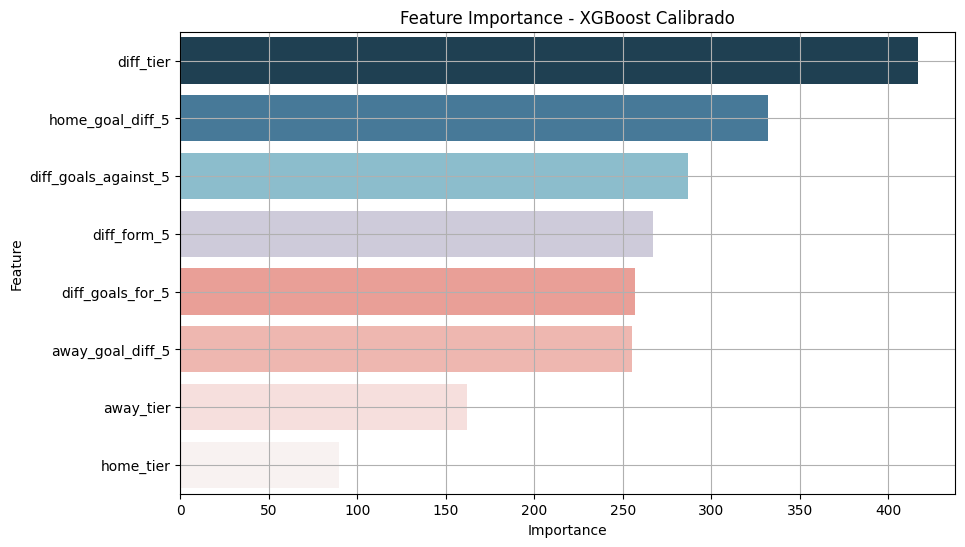

In [61]:
# Accede al booster del primer clasificador dentro del calibrador
# Usasamos cv=5, hay 5 modelos; el .calibrated_classifiers_[0] es suficiente para ver la tendencia
importance = calibrated_xgb.calibrated_classifiers_[0].estimator.get_booster().get_score(importance_type='weight')

# DataFrame de importancia
importance_df = pd.DataFrame(
    list(importance.items()), 
    columns=['Feature', 'Importance']
).sort_values(by='Importance', ascending=False)

# Mostrar resultados
print("Importancia de las variables (XGBoost Calibrado):")
print(importance_df.round(4))

# Gráfico de importancia
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df, palette=palette_colors, hue=features,legend=False)
plt.title('Feature Importance - XGBoost Calibrado')
plt.grid()
plt.show()

In [62]:
# Obtener probabilidades del conjunto de prueba
probs = xgb_model.predict_proba(X_test)

# Crear un DataFrame para comparar
check_df = pd.DataFrame(probs, columns=['Prob_Visitante (A)', 'Prob_Empate (D)', 'Prob_Local (H)'])
check_df['Resultado_Real'] = y_test.values

# Semantica para las columnas A': 0 (Visitante), 'D': 1 (Empate), 'H': 2 (Local)
check_df['Resultado_Real_semántico'] = check_df['Resultado_Real'].map({0: 'A', 1: 'D', 2: 'H'})


# Ver los primeros 10 partidos para validar la "sensatez" del modelo
print("Muestra de Probabilidades Calibradas:")
print(check_df.head(10).round(3))

Muestra de Probabilidades Calibradas:
   Prob_Visitante (A)  Prob_Empate (D)  Prob_Local (H)  Resultado_Real  \
0               0.281            0.298           0.421               0   
1               0.401            0.284           0.315               1   
2               0.312            0.283           0.405               2   
3               0.254            0.276           0.470               2   
4               0.257            0.286           0.457               2   
5               0.220            0.256           0.523               1   
6               0.303            0.287           0.410               2   
7               0.249            0.239           0.512               0   
8               0.252            0.290           0.458               2   
9               0.287            0.303           0.410               0   

  Resultado_Real_semántico  
0                        A  
1                        D  
2                        H  
3                        H  
4 

Comparativa de Rendimiento **(Logistic Regresion vs XGBoost)** y Selección Final

**Resultados Obtenidos:**
- Regresión Logística: Log Loss = 1.0103
- XGBoost: Log Loss = 1.0145

**Conclusiones**

En este trabajo se desarrolló un sistema de predicción de resultados para la Liga MX, utilizando información histórica de desempeño reciente y jerarquía relativa de los equipos. El objetivo principal fue evaluar la capacidad predictiva de distintos enfoques de modelado, priorizando la calidad probabilística y la validez temporal de las predicciones.

La Regresión Logística fue utilizada como modelo base, mostrando un desempeño consistente con un Log Loss de aproximadamente 1.01. Este resultado indica que el modelo logra capturar señal relevante más allá del comportamiento aleatorio, aunque también evidencia las limitaciones inherentes al uso de variables agregadas en un entorno altamente estocástico como el fútbol.

Posteriormente, se implementó un modelo más complejo (XGBoost) bajo el mismo esquema de validación temporal. Los resultados obtenidos no mostraron una mejora significativa respecto al modelo lineal, lo que sugiere que, con el conjunto actual de variables y el volumen de datos disponible, la complejidad adicional no se traduce en una mejor generalización fuera de muestra.

El análisis de calibración probabilística mostró que las predicciones del modelo base son razonablemente estables, y que los intentos de calibración posterior no produjeron mejoras sustanciales en el Log Loss. Esto indica que el principal cuello de botella del sistema no se encuentra en la calibración, sino en la capacidad predictiva de las variables utilizadas.

En conjunto, estos resultados respaldan la selección de la Regresión Logística como modelo final del sistema, al ofrecer un balance adecuado entre desempeño, interpretabilidad y robustez. Este modelo constituye una base sólida para su integración en herramientas de análisis y visualización, como el dashboard desarrollado posteriormente, y establece un punto de partida claro para futuras mejoras mediante la incorporación de nuevas fuentes de información o variables más expresivas.